# **Import Package**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
from matplotlib import pyplot as plt

# **Import data**

In [0]:
CONFIRMED_GLOBAL_0421_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_global_data_0421 = pd.read_csv(CONFIRMED_GLOBAL_0421_URL)
CONFIRMED_US_0421_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
confirmed_us_data_0421 = pd.read_csv(CONFIRMED_US_0421_URL)
confirmed_global_data_0421 = confirmed_global_data_0421.rename(columns={"Country/Region": "Country"})

In [0]:
# New York Data
newyork_confirmed = confirmed_us_data_0421[confirmed_us_data_0421.Province_State == "New York"]
newyork_confirmed = newyork_confirmed.iloc[:,11:]
newyork_confirmed = pd.DataFrame(newyork_confirmed.sum(axis=0))
newyork_confirmed = newyork_confirmed.rename(columns={0:"NewYork"})
newyork_confirmed = newyork_confirmed[newyork_confirmed.NewYork != 0]
max_confirmed = {'NewYork':[1000000]}

max_df = pd.DataFrame(max_confirmed)
newyork_confirmed = pd.concat([max_df, newyork_confirmed])


In [0]:
len(newyork_confirmed)

54

In [0]:
# Spain Data
spain_confirmed = confirmed_global_data_0421[confirmed_global_data_0421.Country == "Spain"]
spain_confirmed = spain_confirmed.iloc[:,4:]
spain_confirmed = spain_confirmed.transpose().rename(columns={201:"Spain"})
spain_confirmed = spain_confirmed[spain_confirmed.Spain != 0]
max_confirmed = {'Spain':[1000000]}

max_df = pd.DataFrame(max_confirmed)
spain_confirmed = pd.concat([max_df, spain_confirmed])

In [0]:
# US data (Overall)
us_confirmed = confirmed_us_data_0421.iloc[:,11:]
us_confirmed = pd.DataFrame(us_confirmed.sum(axis=0))
us_confirmed = us_confirmed.rename(columns={0:'US'})
max_confirmed = {'US':[1000000]}

max_df = pd.DataFrame(max_confirmed)
us_confirmed = pd.concat([max_df, us_confirmed])

In [0]:
# Virginia Data
virginia_confirmed = confirmed_us_data_0421[confirmed_us_data_0421.Province_State == "Virginia"]
virginia_confirmed = virginia_confirmed.iloc[:,11:]
virginia_confirmed = pd.DataFrame(virginia_confirmed.sum(axis=0))
virginia_confirmed = virginia_confirmed.rename(columns={0:"Virginia"})
virginia_confirmed = virginia_confirmed[virginia_confirmed.Virginia != 0]
max_confirmed = {'Virginia':[1000000]}

max_df = pd.DataFrame(max_confirmed)
virginia_confirmed = pd.concat([max_df,virginia_confirmed])

In [0]:
# Italy Data
italy_confirmed = confirmed_global_data_0421[confirmed_global_data_0421.Country == 'Italy']
italy_confirmed = italy_confirmed.iloc[:,11:]
italy_confirmed = pd.DataFrame(italy_confirmed.sum(axis=0))
italy_confirmed = italy_confirmed.rename(columns={0:"Italy"})
italy_confirmed = italy_confirmed[italy_confirmed.Italy != 0]
max_confirmed = {'Italy':[1000000]}

max_df = pd.DataFrame(max_confirmed)
italy_confirmed = pd.concat([max_df,italy_confirmed])

## Prepare the Data

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
newyork_scaled = scaler.fit_transform(newyork_confirmed)[1:]
spain_scaled = scaler.fit_transform(spain_confirmed)[1:]
us_scaled= scaler.fit_transform(us_confirmed)[1:]
virginia_scaled = scaler.fit_transform(virginia_confirmed)[1:]
italy_scaled = scaler.fit_transform(italy_confirmed)[1:]

In [0]:
newyork_scaled.shape

(53, 1)

In [0]:
LAG_OBSERVATIONS_SIZE = 4
PREDICT_SIZE = 2

In [0]:
def DataPrepare(data, lag_obs=5, n_output=5):
    prepared_data = []
    for i in range(len(data) - lag_obs - n_output + 1):
        prepared_data.append(np.array(data[i:i + lag_obs]))
    return np.array(prepared_data)

def LabelPrepare(data, lag_obs=5, n_output=5):
    prepared_label = []
    for i in range((0 + lag_obs), (len(data) - n_output + 1)):
      tmp = []
      for j in range(i, (i + n_output)):
        tmp.append(data[j][0])

      prepared_label.append(tmp)       
    return np.array(prepared_label)

def PredPrepare(data, lag_obs=5, n_output=5):
    prepared_data = []
    for i in range(len(data) - lag_obs + 1):
        prepared_data.append(np.array(data[i:i + lag_obs]))
    return np.array(prepared_data)


In [0]:
newyork_X_prepared = DataPrepare(newyork_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)
newyork_y_prepared = LabelPrepare(newyork_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)

In [0]:
virginia_X_prepared = DataPrepare(virginia_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)
virginia_y_prepared = LabelPrepare(virginia_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)

In [0]:
italy_X_prepared = DataPrepare(italy_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)
italy_y_prepared = LabelPrepare(italy_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)

In [0]:
us_X_prepared = DataPrepare(us_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)
us_y_prepared = LabelPrepare(us_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)

In [0]:
spain_X_prepared = DataPrepare(spain_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)
spain_y_prepared = LabelPrepare(spain_scaled, LAG_OBSERVATIONS_SIZE, PREDICT_SIZE)

In [0]:
# For predictions
newyork_pred_prepared = PredPrepare(newyork_scaled, LAG_OBSERVATIONS_SIZE)
virginia_pred_prepared = PredPrepare(virginia_scaled, LAG_OBSERVATIONS_SIZE)
italy_pred_prepared = PredPrepare(italy_scaled, LAG_OBSERVATIONS_SIZE)
spain_pred_prepared = PredPrepare(spain_scaled, LAG_OBSERVATIONS_SIZE)
us_pred_prepared = PredPrepare(us_scaled, LAG_OBSERVATIONS_SIZE)

# **Build LSTM Model**

## **Model 1 (New York)**

In [0]:
numPoints, numFeatures = 4, 1

model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(numPoints, numFeatures)))
model1.add(tf.keras.layers.Dropout(rate=0.4))
model1.add(tf.keras.layers.LSTM(128, return_sequences=True))
model1.add(tf.keras.layers.Dropout(rate=0.4))
model1.add(tf.keras.layers.LSTM(64, activation='elu'))
model1.add(tf.keras.layers.Dense(2))
# optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model1.compile(
        optimizer='adam', 
        loss='mae',
        metrics = ["accuracy"])

In [0]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 256)            264192    
_________________________________________________________________
dropout (Dropout)            (None, 4, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
__________________________________________________

In [0]:
history = model1.fit(newyork_X_prepared, newyork_y_prepared, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0864 - accuracy: 0.3750
Epoch 2/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0859 - accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0788 - accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0713 - accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0634 - accuracy: 1.0000
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0606 - accuracy: 1.0000
Epoch 7/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0501 - accuracy: 0.8750
Epoch 8/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0324 - accuracy: 0.2500
Epoch 9/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0137 - accuracy: 0.1875
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0183 - accuracy: 0.4792
Epoch 11/100
2/2 [=

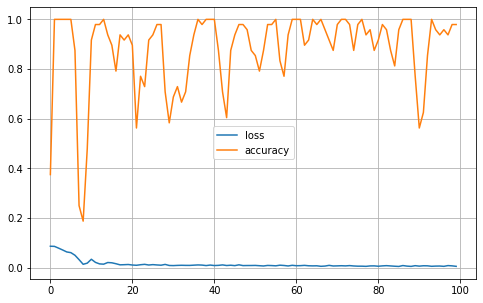

In [0]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

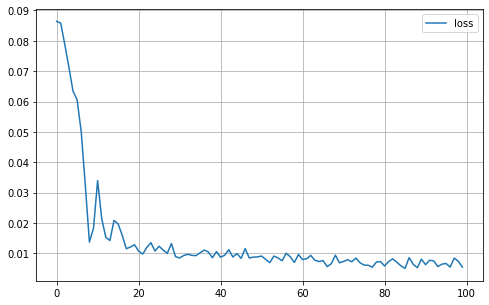

In [0]:
pd.DataFrame(history.history['loss'], columns=['loss']).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

In [0]:
prediction = []
day = 22
month = 4
for i in range (30):
  predX = model1.predict(newyork_pred_prepared)
  predX = scaler.inverse_transform(predX)

  prediction.append(predX[-1][0])

  pred = {"NewYork":[predX[-1][0]]}
  pred_df = pd.DataFrame(pred)
  date = ""
  if day > 30:
    day = 1
    month = 5
  date = str(month)+"/"+str(day)+"/20"
  pred_df = pred_df.rename(index = {0:date})
  newyork_confirmed = pd.concat([newyork_confirmed, pred_df])
  newyork_scaled = scaler.fit_transform(newyork_confirmed)[1:]
  newyork_pred_prepared = PredPrepare(newyork_scaled, LAG_OBSERVATIONS_SIZE)
  day += 1

In [0]:
newyork_confirmed = newyork_confirmed.reset_index()

In [0]:
newyork_confirmed = newyork_confirmed.iloc[1:,]

In [0]:
newyork_confirmed

,index,NewYork
2,3/3/20,2.00000
3,3/4/20,11.00000
4,3/5/20,23.00000
5,3/6/20,31.00000
6,3/7/20,76.00000
...,...,...
77,5/17/20,300744.53125
78,5/18/20,300873.50000
79,5/19/20,300984.03125
80,5/20/20,301078.71875


In [0]:
from google.colab import files
newyork_confirmed.to_csv('newyork_confirmed.csv') 
files.download('newyork_confirmed.csv')

## **Model 2 (Spain)**

In [0]:
numPoints, numFeatures = 4, 1

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(numPoints, numFeatures)))
model2.add(tf.keras.layers.Dropout(rate=0.2))
model2.add(tf.keras.layers.LSTM(128, return_sequences=True))
model2.add(tf.keras.layers.LSTM(64, activation='relu'))
model2.add(tf.keras.layers.Dense(2))

model2.compile(
        optimizer='adam', 
        loss='mae',
        metrics = ["accuracy"])

In [0]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 256)            264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history2 = model2.fit(spain_X_prepared, spain_y_prepared, epochs=200)

Epoch 1/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0581 - accuracy: 0.2436
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0586 - accuracy: 0.4615
Epoch 3/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0530 - accuracy: 0.6154
Epoch 4/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0539 - accuracy: 0.5641
Epoch 5/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0464 - accuracy: 0.4872
Epoch 6/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0398 - accuracy: 0.4744
Epoch 7/200
3/3 [==============================] - 0s 17ms/step - loss: 0.0285 - accuracy: 0.3590
Epoch 8/200
3/3 [==============================] - 0s 17ms/step - loss: 0.0143 - accuracy: 0.2564
Epoch 9/200
3/3 [==============================] - 0s 17ms/step - loss: 0.0160 - accuracy: 0.5256
Epoch 10/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0145 - accuracy: 0.7692
Epoch 11/200
3/3 [=

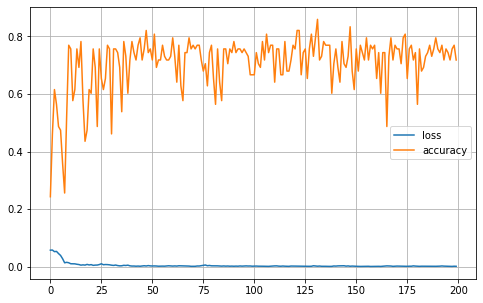

In [0]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

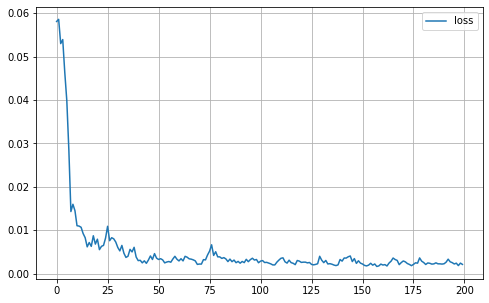

In [0]:
pd.DataFrame(history2.history['loss'], columns=['loss']).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

In [0]:
prediction2 = []
day = 22
month = 4
for i in range (30):
  predX2 = model2.predict(spain_pred_prepared)
  predX2 = scaler.inverse_transform(predX2)

  prediction2.append(predX2[-1][0])

  pred = {"Spain":[predX2[-1][0]]}
  pred_df = pd.DataFrame(pred)
  date = ""
  if day > 30:
    day = 1
    month = 5
  date = str(month)+"/"+str(day)+"/20"
  pred_df = pred_df.rename(index = {0:date})
  spain_confirmed = pd.concat([spain_confirmed, pred_df])
  spain_scaled = scaler.fit_transform(spain_confirmed)[1:]
  spain_pred_prepared = PredPrepare(spain_scaled, LAG_OBSERVATIONS_SIZE)
  day += 1


In [0]:
prediction2


[215804.23,
 207320.06,
 209811.53,
 212961.44,
 215606.38,
 213624.05,
 215446.08,
 216994.23,
 217758.64,
 217674.22,
 218745.83,
 219492.45,
 219894.92,
 220204.22,
 220803.52,
 221212.84,
 221506.61,
 221805.3,
 222150.22,
 222405.45,
 222623.1,
 222840.77,
 223050.45,
 223220.25,
 223374.38,
 223521.6,
 223655.19,
 223770.02,
 223875.6,
 223973.31]

In [0]:
spain_confirmed.iloc[80:]

,Spain
4/20/20,200210.000000
4/21/20,204178.000000
4/22/20,215804.234375
4/23/20,207320.062500
4/24/20,209811.531250
4/25/20,212961.437500
4/26/20,215606.375000
4/27/20,213624.046875
4/28/20,215446.078125
4/29/20,216994.234375


In [0]:
from google.colab import files
spain_confirmed.to_csv('spain_confirmed.csv') 
files.download('spain_confirmed.csv')

## **Model 3 (Virginia)**

In [0]:
numPoints, numFeatures = 4, 1

model_va = tf.keras.models.Sequential()
model_va.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(numPoints, numFeatures)))
model_va.add(tf.keras.layers.Dropout(rate=0.6))
model_va.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_va.add(tf.keras.layers.Dropout(rate=0.6))
model_va.add(tf.keras.layers.LSTM(64, activation='elu'))
model_va.add(tf.keras.layers.Dense(2))
# optimizer=tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9)
model_va.compile(
        optimizer="adam", 
        loss='mae',
        metrics = ["accuracy"])

In [0]:
print(model_va.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 256)            264192    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 4, 128)            197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
________________________________________________

In [0]:
history3 = model_va.fit(virginia_X_prepared, virginia_y_prepared, epochs=100)

Epoch 1/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.4524
Epoch 2/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0055 - accuracy: 0.9524
Epoch 3/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0022 - accuracy: 0.7857
Epoch 4/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0037 - accuracy: 0.0238
Epoch 5/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 0.6429
Epoch 6/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0032 - accuracy: 0.9762
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.9762
Epoch 8/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 0.8333
Epoch 9/100
2/2 [==============================] - 0s 14ms/step - loss: 0.0032 - accuracy: 0.4286
Epoch 10/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 0.4048
Epoch 11/100
2/2 [=

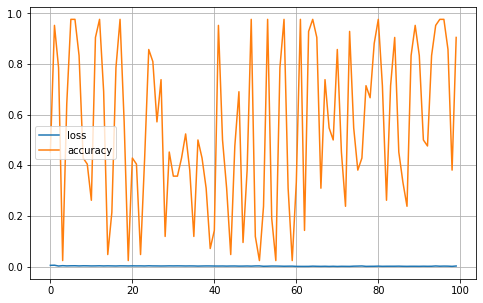

In [0]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

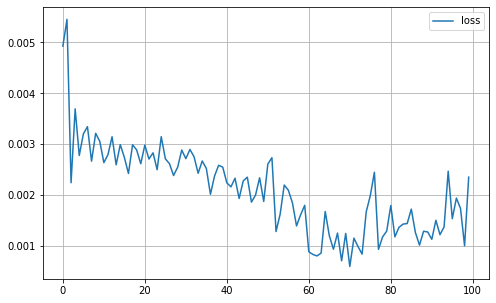

In [0]:
pd.DataFrame(history3.history['loss'], columns=['loss']).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

In [0]:
prediction3 = []

day = 23
month = 4
for i in range (29):
  predX = model_va.predict(virginia_pred_prepared)
  predX = scaler.inverse_transform(predX)

  prediction3.append(predX[-1][0])

  pred = {"Virginia":[predX[-1][0]]}
  pred_df = pd.DataFrame(pred)
  date = ""
  if day > 30:
    day = 1
    month = 5
  date = str(month)+"/"+str(day)+"/20"
  pred_df = pred_df.rename(index = {0:date})
  virginia_confirmed = pd.concat([virginia_confirmed, pred_df])
  virginia_scaled = scaler.fit_transform(virginia_confirmed)[1:]
  virginia_pred_prepared = PredPrepare(virginia_scaled, LAG_OBSERVATIONS_SIZE)
  day += 1

In [0]:
prediction3

[10072.129,
 10574.375,
 11076.558,
 11442.09,
 11605.392,
 12070.666,
 12480.928,
 12810.329,
 13118.058,
 13540.864,
 13916.499,
 14262.265,
 14622.345,
 15019.936,
 15390.405,
 15755.07,
 16133.01,
 16520.768,
 16896.416,
 17273.992,
 17658.975,
 18045.785,
 18428.572,
 18814.459,
 19203.938,
 19593.74,
 19983.053,
 20374.857,
 20768.479]

In [0]:
virginia_confirmed.iloc[40:,]

,Virginia
4/16/20,6889.000000
4/17/20,7491.000000
4/18/20,8053.000000
4/19/20,8542.000000
4/20/20,8990.000000
4/21/20,9630.000000
4/22/20,10266.000000
4/23/20,10072.128906
4/24/20,10574.375000
4/25/20,11076.557617


In [0]:
from google.colab import files
virginia_confirmed.to_csv('virginia_confirmed.csv') 
files.download('virginia_confirmed.csv')

## **Model 4 (Italy)**

In [0]:
numPoints, numFeatures = 4, 1

model_italy = tf.keras.models.Sequential()
model_italy.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(numPoints, numFeatures)))
model_italy.add(tf.keras.layers.Dropout(rate=0.25))
model_italy.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_italy.add(tf.keras.layers.Dropout(rate=0.25))
model_italy.add(tf.keras.layers.LSTM(64, activation='elu'))
model_italy.add(tf.keras.layers.Dense(2))
# optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model_italy.compile(
        optimizer='adam', 
        loss='mae',
        metrics = ["accuracy"])

In [0]:
print(model_italy.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4, 256)            264192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 128)            197120    
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
________________________________________________

In [0]:
history4 = model_italy.fit(italy_X_prepared, italy_y_prepared, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0571 - accuracy: 0.7975
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0536 - accuracy: 0.7595
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0461 - accuracy: 0.6582
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0405 - accuracy: 0.8228
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0239 - accuracy: 0.7722
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0123 - accuracy: 0.6582
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0159 - accuracy: 0.4557
Epoch 8/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0145 - accuracy: 0.4304
Epoch 9/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0098 - accuracy: 0.7468
Epoch 10/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0099 - accuracy: 0.7975
Epoch 11/100
3/3 [=

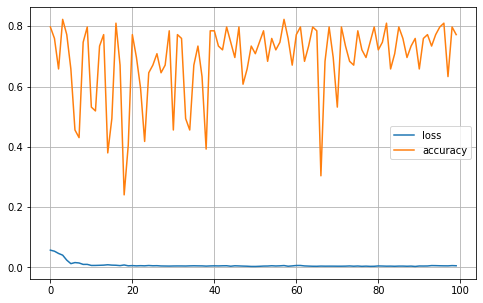

In [0]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

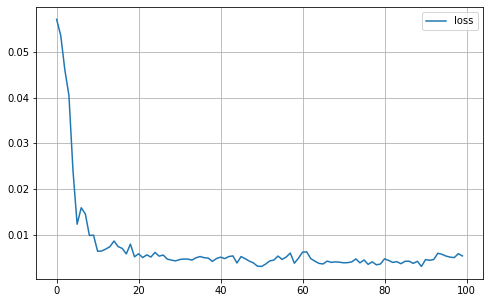

In [0]:
pd.DataFrame(history4.history['loss'], columns=['loss']).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

In [0]:
prediction4 = []
day = 23
month = 4
for i in range (29):
  predX = model_italy.predict(italy_pred_prepared)
  predX = scaler.inverse_transform(predX)

  prediction4.append(predX[-1][0])

  pred = {"Italy":[predX[-1][0]]}
  pred_df = pd.DataFrame(pred)
  date = ""
  if day > 30:
    day = 1
    month = 5
  date = str(month)+"/"+str(day)+"/20"
  pred_df = pred_df.rename(index = {0:date})
  italy_confirmed = pd.concat([italy_confirmed, pred_df])
  italy_scaled = scaler.fit_transform(italy_confirmed)[1:]
  italy_pred_prepared = PredPrepare(italy_scaled, LAG_OBSERVATIONS_SIZE)
  day += 1

In [0]:
prediction4

[193355.44,
 195627.48,
 198379.44,
 201472.64,
 204625.11,
 206634.47,
 208822.05,
 210976.58,
 212891.16,
 214440.12,
 215982.27,
 217402.4,
 218647.38,
 219742.4,
 220773.84,
 221700.61,
 222521.38,
 223259.19,
 223934.12,
 224537.0,
 225075.19,
 225559.94,
 225997.39,
 226388.14,
 226738.05,
 227052.47,
 227334.66,
 227586.95,
 227812.9]

In [0]:
italy_confirmed.iloc[60:,]

,Italy
3/30/20,101739.000000
3/31/20,105792.000000
4/1/20,110574.000000
4/2/20,115242.000000
4/3/20,119827.000000
4/4/20,124632.000000
4/5/20,128948.000000
4/6/20,132547.000000
4/7/20,135586.000000
4/8/20,139422.000000


In [0]:
from google.colab import files
italy_confirmed.to_csv('italy_confirmed.csv') 
files.download('italy_confirmed.csv')

In [0]:
from google.colab import files
us_confirmed.to_csv('us_confirmed.csv') 
files.download('us_confirmed.csv')

## **Model 5(US)**

In [0]:
numPoints, numFeatures = 4, 1

model_us = tf.keras.models.Sequential()
model_us.add(tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(numPoints, numFeatures)))
model_us.add(tf.keras.layers.Dropout(rate=0.2))
model_us.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_us.add(tf.keras.layers.Dropout(rate=0.2))
model_us.add(tf.keras.layers.LSTM(64, activation='elu'))
model_us.add(tf.keras.layers.Dense(2))
# optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model_us.compile(
        optimizer='adam', 
        loss='mae',
        metrics = ["accuracy"])

In [0]:
print(model_us.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4, 256)            264192    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 4, 128)            197120    
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 510,850
Trainable params: 510,850
Non-trainable params: 0
________________________________________________

In [0]:
history5 = model_us.fit(us_X_prepared, us_y_prepared, epochs=100)

Epoch 1/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1486 - accuracy: 0.3750
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.1419 - accuracy: 0.4205
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1299 - accuracy: 0.4318
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1096 - accuracy: 0.2955
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0650 - accuracy: 0.3295
Epoch 6/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0360 - accuracy: 0.3864
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0533 - accuracy: 0.3750
Epoch 8/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0259 - accuracy: 0.6591
Epoch 9/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0226 - accuracy: 0.6136
Epoch 10/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0228 - accuracy: 0.6477
Epoch 11/100
3/3 [=

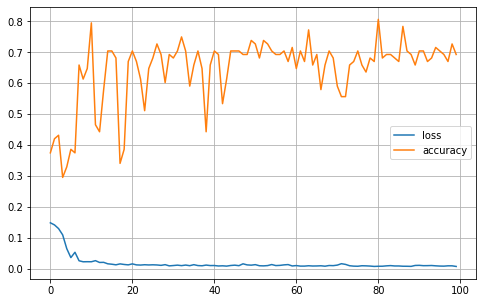

In [0]:
pd.DataFrame(history5.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

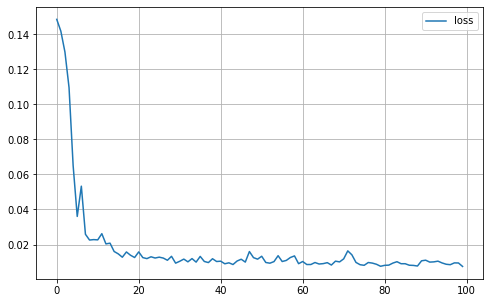

In [0]:
pd.DataFrame(history5.history['loss'], columns=['loss']).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 0.2)
plt.show()

In [0]:
prediction5 = []

day = 23
month = 4
for i in range (29):
  predX5 = model_us.predict(us_pred_prepared)
  predX5 = scaler.inverse_transform(predX5)

  prediction5.append(predX5[-1][0])

  pred = {"US":[predX5[-1][0]]}
  pred_df = pd.DataFrame(pred)
  date = ""
  if day > 30:
    day = 1
    month = 5
  date = str(month)+"/"+str(day)+"/20"
  pred_df = pred_df.rename(index = {0:date})
  us_confirmed = pd.concat([us_confirmed, pred_df])
  us_scaled = scaler.fit_transform(us_confirmed)[1:]
  us_pred_prepared = PredPrepare(us_scaled, LAG_OBSERVATIONS_SIZE)
  day += 1

In [0]:
prediction5

[859443.5,
 881603.94,
 903491.4,
 923497.06,
 940772.56,
 958438.44,
 975084.75,
 990240.5,
 1004168.94,
 1018665.06,
 1034670.7,
 1050294.4,
 1065675.9,
 1081532.4,
 1097975.9,
 1114437.6,
 1131005.5,
 1147933.0,
 1165205.1,
 1182653.4,
 1200325.4,
 1218305.9,
 1236578.1,
 1255094.6,
 1273879.8,
 1292962.2,
 1312335.1,
 1331988.5,
 1351934.2]

In [0]:
us_confirmed.iloc[70:,]

,US
3/31/20,1.881720e+05
4/1/20,2.132420e+05
4/2/20,2.436220e+05
4/3/20,2.753670e+05
4/4/20,3.086500e+05
4/5/20,3.368020e+05
4/6/20,3.663170e+05
4/7/20,3.971210e+05
4/8/20,4.286540e+05
4/9/20,4.627800e+05
